In [1]:
import math
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib_venn import venn3

In [53]:
class Search_Result():
    def __init__(self, filename='', identifier='', 
                 search_workflow='ID_PD'):
        """use resultname.filename, resultname.identifier, etc.
        
        could extend more using a method for i/o.
        also could save in class.
        """
        self.filename = filename  # implies where to read
        self.identifier = identifier
        self.search_workflow = search_workflow  # ID/Quan_search engine (top-down hierarchy)

    def read_result(self):
        # output: self.raw_result, self.result
        # a dict {protein: protein_result, peptide: peptide_result, PSM: PSM_result}
        self.raw_result = {}
        if self.search_workflow == 'ID_PD':
            suffix = {'PSM': self.filename + '_PSMs.txt',
                      'peptide': self.filename + '_PeptideGroups.txt',
                      'protein': self.filename + '_Proteins.txt'}
            for key in suffix:
                self.raw_result[key] = pd.read_csv(suffix[key], sep = '\t')
                self.raw_result[key]['Identifier'] = self.identifier
                
        # raw result to final result
        self.result = {}
        if self.search_workflow == 'ID_PD':
            # select columns 
            # protein: no change, only filter columns
            protein_cols = ['Identifier', 'Accession', 'Exp. q-value: Combined', 'Coverage [%]']
            self.result['protein'] = self.raw_result['protein'][protein_cols]
            
            # peptide: add a new Mod_sequence column
            peptide_cols = ['Identifier', 'Mod_sequence', 'Qvality PEP', 
                            'Qvality q-value', 'Master Protein Accessions', 
                            '# Missed Cleavages']
            peptide = self.raw_result['peptide']
            peptide['Modifications'] = peptide['Modifications'].fillna('')
            peptide['Mod_sequence'] = peptide['Sequence'] +'.'+ peptide['Modifications'] 
            self.result['peptide'] = peptide[peptide_cols]
            
            # PSM: add a new Mod_sequence column
            PSM_cols = ['Identifier', 'Mod_sequence','Spectrum File', 'First Scan',  
                        'Precursor Abundance', 'Intensity','Percolator q-Value', 'Percolator PEP',
                        'Master Scan(s)', 'Isolation Interference [%]', 
                        'RT [min]','Master Protein Accessions']
            PSM = self.raw_result['PSM']
            PSM['Modifications'] = PSM['Modifications'].fillna('')
            PSM['Mod_sequence'] = PSM['Sequence'] +'.'+ PSM['Modifications'] 
            self.result['PSM'] = PSM[PSM_cols]
        return self


def protein_result_to_db(protein_database, protein_result):
    """read protein result to database.
    input:
        - protein_database: pd.dataframe with normalized column name
        - protein_result: transformed raw result 
    output:
        - updated protein_database
    """
    # filter related columns
    result = protein_result[protein_database.columns]
    # append
    protein_database = protein_database.append(result)
    return protein_database


def filter_protein_count(protein_db):
    # protein filter
    protein_fdr = protein_db[protein_db['Exp. q-value: Combined'] < 0.01]
    pivot = pd.pivot_table(protein_fdr, values='Accession',
                           index='File', aggfunc='count')
    # flatten pivot table to normal df
    flatten = pd.DataFrame(pivot.to_records())
    return flatten

In [57]:
df1 = Search_Result(filename='test/two_files-PD_output/19-149_HM0522_GM-1', identifier='overnight', 
                    search_workflow='ID_PD')
print(df1.filename)
df1 = df1.read_result()
print(df1.raw_result['peptide'].shape)
print(df1.result['peptide'].shape)
df1.result['peptide']

print(df1.raw_result['protein'].columns)

df1.raw_result['protein']['Master']

test/two_files-PD_output/19-149_HM0522_GM-1
(8804, 48)
(8804, 6)
Index(['Checked', 'Protein FDR Confidence: Combined', 'Master',
       'Unique Sequence ID', 'Protein Group IDs', 'Accession', 'Description',
       'Sequence', 'FASTA Title Lines', 'Exp. q-value: Combined',
       'Sum PEP Score', '# Decoy Protein: Combined', 'Coverage [%]',
       '# Peptides', '# PSMs', '# Protein Unique Peptides',
       '# Unique Peptides', '# AAs', 'MW [kDa]', 'calc. pI',
       'Score Sequest HT: Sequest HT',
       'Coverage [%] (by Search Engine): Sequest HT',
       '# PSMs (by Search Engine): Sequest HT',
       '# Peptides (by Search Engine): Sequest HT', '# Razor Peptides',
       'Abundances (Scaled): F1: Sample',
       'Abundances (Normalized): F1: Sample', 'Abundance: F1: Sample',
       'Abundances Count: F1: Sample', 'Found in Sample: [S1] F1: Sample',
       'Found in Sample Group: [S1] F1: Sample', '# Protein Groups',
       'Modifications', 'Identifier'],
      dtype='object')


0                        IsMasterProtein
1                                   None
2                                   None
3                        IsMasterProtein
4                        IsMasterProtein
5                                   None
6                                   None
7                                   None
8                        IsMasterProtein
9                        IsMasterProtein
10                                  None
11                       IsMasterProtein
12                                  None
13                                  None
14                                  None
15                       IsMasterProtein
16                                  None
17                       IsMasterProtein
18                                  None
19                                  None
20                                  None
21                                  None
22                       IsMasterProtein
23                       IsMasterProtein
24              

In [4]:
# test of `read_PD_result`
df1 = read_PD_result(
    'test/two_files-PD_output/19-149_HM0522_GM-1', 
    filename='overnight'
)
df2 = read_PD_result(
    'test/two_files-PD_output/19-149_HM0522_GM-2',
    filename='2x digestion'
)

In [6]:
# test of `protein_result_to_db`
protein_db = pd.DataFrame(columns=["Accession", "Exp. q-value: Combined", "Coverage [%]", "File"])
# protein_db = read_protein(protein_db, df1['protein'])

protein_db = protein_result_to_db(protein_db, df1['protein'])
print(protein_db.shape)
protein_db = protein_result_to_db(protein_db, df2['protein'])
print(protein_db.shape)
print(protein_db[:10])
print(protein_db[-10:])
# print(protein_db)

(6788, 4)
(13332, 4)
    Accession  Exp. q-value: Combined Coverage [%]       File
0      E9PQH6                     0.0           67  overnight
1      E5RIC7                     0.0            5  overnight
2      H7C2Y5                     0.0            7  overnight
3      O95881                     0.0            8  overnight
4      E9PD92                     0.0           20  overnight
5  A0A2R8Y706                     0.0            5  overnight
6      M0R1V7                     0.0           70  overnight
7      Q5TA01                     0.0            9  overnight
8      Q13423                     0.0            3  overnight
9      P06734                     0.0           21  overnight
       Accession  Exp. q-value: Combined Coverage [%]          File
6534      P30613                   0.000            3  2x digestion
6535  A0A087WY10                   0.000           56  2x digestion
6536      X6R2P6                   0.000           24  2x digestion
6537      B7Z8J4         

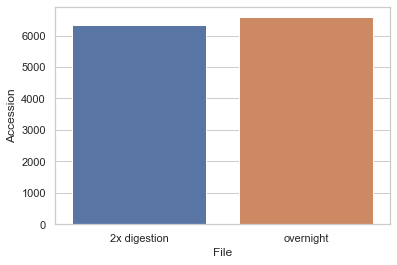

In [7]:
# init protein bar plot
# protein read from meta table
# a demo picture: filter by all and protein q.value < 0.01

result = filter_protein_count(protein_db)
# print(type(result))
# print(result['Accession'])
# result['File']
# type(result)
sns.set(style="whitegrid")
sns.barplot(x='File', y='Accession', data=result)